<a href="https://colab.research.google.com/github/NguyenThien19146131/Thien/blob/main/Music_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub
!pip install librosa
!pip install numba==0.49.0
!pip install llvmlite==0.32.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.6 MB 5.0 MB/s 
     |████████████████████████████████| 20.2 MB 1.3 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import random
import shutil
from pydub import AudioSegment
from matplotlib.backends.backend_agg import FigureCanvasAgg
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
try:
  os.makedirs('/content/spectrograms')
  os.makedirs('/content/audio_samples')
except FileExistsError:
  pass

Mounted at /content/gdrive


In [4]:
genres = 'blues classical country disco pop hiphop metal rock reggae '
genres = genres.split()

In [5]:
for g in genres:
  path1=os.path.join('/content/gdrive/MyDrive/Data/audio_samples', f'{g}')
  try:
    os.makedirs(path1)
  except FileExistsError:
    pass
  path=os.path.join('/content/gdrive/MyDrive/Data/spectrograms',f'{g}')
  try:
    os.makedirs(path)
  except FileExistsError:
    pass


In [ ]:
i = 0
for g in genres:
    j = 0
    print(f"{g}")
    directory = '/content/gdrive/MyDrive/Data/genres_original'    

    for filename in os.listdir(os.path.join(directory, f"{g}")):
        song = os.path.join(f'{directory}/{g}', f'{filename}')
        j += 1

        for w in range(0, 10):
            i += 1
            t1 = 3 * w * 1000
            t2 = 3 * (w + 1) * 1000
            newAudio = AudioSegment.from_wav(song)
            new = newAudio[t1:t2]            
            new.export(f'/content/gdrive/MyDrive/Data/audio_samples/{g}/{g}{j}{w}.wav', format="wav")           

blues
classical
country
disco
pop
hiphop
metal
rock
reggae


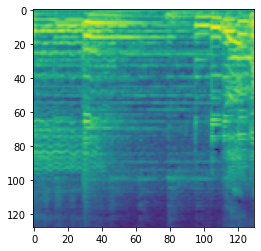

In [14]:
directory = '/content/gdrive/MyDrive/Data/genres_original'
for g in genres:
    j = 0
    print(g)
    for filename in os.listdir(os.path.join(directory, f"{g}")):
        song = os.path.join(f'{directory}/{g}', f'{filename}')
        j = j+1
        y, sr = librosa.load(song, duration=3)
        mels = librosa.feature.melspectrogram(y=y, sr=sr)
        fig = plt.Figure()
        canvas = FigureCanvasAgg(fig)
        p = plt.imshow(librosa.power_to_db(mels, ref=np.max))       
        plt.savefig(f'/content/gdrive/MyDrive/Data/spectrograms/train/{g}/{g}{j}.png')

In [14]:
# create a directory train and split test data
directory = "/content/gdrive/MyDrive/Data/spectrograms/train/"
print(directory)
for g in genres:
    filenames = os.listdir(os.path.join(directory, f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:10]
    for f in test_files:
        shutil.copy(f"{directory}{g}/{f}", f"{directory[:-6]}test/{g}")

/content/gdrive/MyDrive/Data/spectrograms/train/


In [16]:
directory = "/content/gdrive/MyDrive/Data/spectrograms/train/"
train_directory = directory
train_data_generator = ImageDataGenerator(rescale=1./255)
train_generator = train_data_generator.flow_from_directory(train_directory, target_size=(
    288, 432), color_mode="rgba", class_mode='categorical', batch_size=128)

validation_directory = "/content/gdrive/MyDrive/Data/spectrograms/test"
validation_data_generator = ImageDataGenerator(rescale=1./255)
validation_generator = validation_data_generator.flow_from_directory(validation_directory, target_size=(
    288, 432), color_mode='rgba', class_mode='categorical', batch_size=128)

Found 900 images belonging to 9 classes.
Found 90 images belonging to 9 classes.


In [15]:
f"{directory}{g}/{f}", f"{directory[:-6]}test/{g}"

('/content/gdrive/MyDrive/Data/spectrograms/train/reggae/reggae87.png',
 '/content/gdrive/MyDrive/Data/spectrograms/test/reggae')

In [17]:
def cnn(input_shape=(288, 432, 4), classes=9):
    def step(dim, X):
        X = Conv2D(dim, kernel_size=(3, 3), strides=(1, 1))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        return MaxPooling2D((2, 2))(X)
    X_input = Input(input_shape)
    X = X_input
    layer_dims = [8, 16, 32, 64, 128, 256]
    for dim in layer_dims:
        X = step(dim, X)

    X = Flatten()(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(classes, activation='softmax',
              name=f'fc{classes}',  kernel_initializer=glorot_uniform(seed=9))(X)
    model = Model(inputs=X_input, outputs=X, name='cnn')
    return model

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [18]:
model = cnn(input_shape=(288, 432, 4), classes=9)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 286, 430, 8)       296       
                                                                 
 batch_normalization_6 (Batc  (None, 286, 430, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 143, 215, 8)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 141, 213, 16)      1168    

In [22]:
history = model.fit(train_generator, epochs=100, validation_data=validation_generator)

Epoch 1/100
8/8 [==============================] - 9s 1s/step - loss: 0.4211 - accuracy: 0.8756 - f1_score: 0.8013 - val_loss: 0.4552 - val_accuracy: 0.8778 - val_f1_score: 0.8304
Epoch 2/100
8/8 [==============================] - 8s 944ms/step - loss: 0.4654 - accuracy: 0.8544 - f1_score: 0.8365 - val_loss: 0.3418 - val_accuracy: 0.9333 - val_f1_score: 0.9123
Epoch 3/100
8/8 [==============================] - 8s 960ms/step - loss: 0.4330 - accuracy: 0.8778 - f1_score: 0.8262 - val_loss: 0.3163 - val_accuracy: 0.9444 - val_f1_score: 0.9349
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.4289 - accuracy: 0.8811 - f1_score: 0.8675 - val_loss: 0.3306 - val_accuracy: 0.9556 - val_f1_score: 0.9302
Epoch 5/100
8/8 [==============================] - 8s 958ms/step - loss: 0.4085 - accuracy: 0.8878 - f1_score: 0.8601 - val_loss: 0.3336 - val_accuracy: 0.9222 - val_f1_score: 0.9006
Epoch 6/100
8/8 [==============================] - 8s 956ms/step - loss: 0.3988 - accuracy:

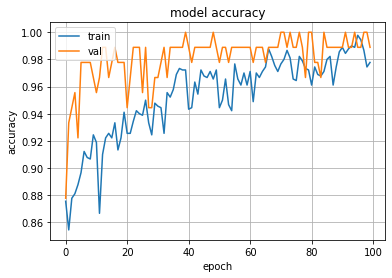

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()

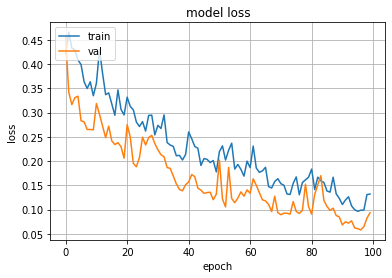

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()